# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Описание данных

**Признаки**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак**
- Price — цена (евро)

## Подготовка данных

Подгружаю необходимые библиотеки и открываю файл с данными.

In [1]:
!pip install catboost
!pip install lightgbm

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import time
import warnings
warnings.filterwarnings('ignore')

In [3]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('/autos (2).csv')

Теперь рассмотрю данные представленные в датасете.

In [4]:
df.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
start = df.shape[0]

Рассмотрю количество пропусков в колонках, статистические данные и количество явных дубликатов.

In [7]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [8]:
columns = []
percents = []
for col in df.columns:
    pct_missing = np.mean(df[col].isna())
    if pct_missing > 0:
        percent = round(pct_missing * 100, 2)
        print(f'{col} - {percent}%')
        columns.append(col)
        percents.append(percent)

VehicleType - 10.58%
Gearbox - 5.6%
Model - 5.56%
FuelType - 9.28%
Repaired - 20.08%


In [9]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [10]:
df.duplicated().sum()

4

Глядя на данные, можно заметить, что:
- В наименовании колонок не однородный регистр и названия столбцов не соответствуют "змеиному стилю". Приведу наименование колонок в соответствие. 
- Есть пропуски в категориальных признаках, которые отображают информацию об автомобиле. Наибольшее количество пропусков в колонках с указанием типа топлива и кузова автомобиля, а также информация о том, был ли ранее автомобиль в ремонте. Процент пропущенных данных очень высок, и удаление пропусков может привести в дальнейшем к снижению качества модели. Поэтому принимаю решение заполнить пропуски.
- Обнаружены явные дубликаты, удалю их. 
- В датасете присутствуют неинформативные признаки, удалю их.
- В таблице с основными статистическими характеристиками видны аномальные значения. Необходимо рассмотреть данные на наличие аномальных значений и исключить их.

Удаляю явные дубликаты.

In [11]:
df = df.drop_duplicates()

In [12]:
df.duplicated().sum()

0

Посмотрю на дату скачивания анкеты из базы, она же соответствует дате создания анкеты, позже которой не может быть год регистрации автомобиля.

In [13]:
print('Последняя дата скачивания анкеты из базы:', df['DateCrawled'].max())

Последняя дата скачивания анкеты из базы: 2016-04-07 14:36:58


Далее удалю колонки с неинформативными признаками. Признаки - дата скачивания анкеты и базы, дата создания анкеты, количество фотографий автомобиля и дата последней активности пользователя точно не понадобятся для предсказания стоимости автомобиля, так как никак не могут влиять на нее.
А значения почтового индекса владельца анкеты (пользователя) сокращу до первой цифры, так как после рассмотрения индексов на стороннем сайте, первая цифра индекса отображает регион, а регион может хоть и слабо, но влиять на стоимость.

In [14]:
df['PostalCode'] = df['PostalCode'] // 10000

In [15]:
df = df.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'LastSeen'], axis=1)
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,7
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,6
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,9
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,9
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,6


Привожу наименование колонок в соответствие.

In [16]:
df = df.rename(columns={'VehicleType': 'Vehicle_Type', 
                        'RegistrationYear': 'Registration_Year',
                        'RegistrationMonth': 'Registration_Month',
                        'FuelType': 'Fuel_Type',
                        'PostalCode': 'Postal_Code'})

In [17]:
df.columns = df.columns.str.lower()
df.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired', 'postal_code'],
      dtype='object')

Посмотрю, как коррелируют оставшиеся признаки с целевым признаком.

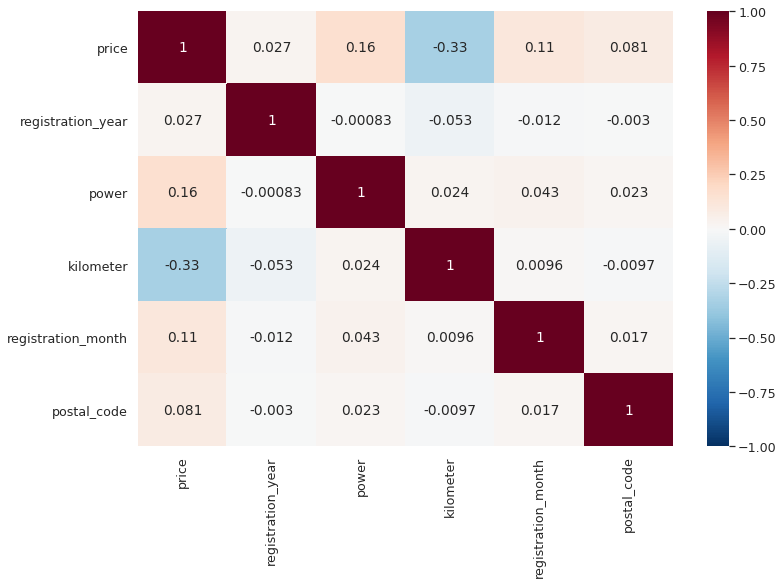

In [18]:
sns.set(font_scale=1.15)
plt.figure(figsize=(12,8))
sns.heatmap(
    df.corr(),        
    cmap='RdBu_r', 
    annot=True, 
    vmin=-1, vmax=1)
plt.show()

Пока признаки особо не коррелируют с целевым признаком, необходимо рассмотреть аномалии и исключить их. Затем снова можно будет посмотреть на корреляцию.

In [19]:
def distribution(df, column):
    plt.figure(figsize=(15,3))
    sns.boxplot(x=df)
    plt.title(f'Распределение колонки {column}')
    plt.grid(True)

    plt.figure(figsize=(15,5))
    plt.hist(df, edgecolor='k', bins=80)
    plt.title(f'Распределение колонки {column}')
    plt.show()
    print(f'Уникальные значения признака: {column}', df.sort_values().unique())

Первым делом рассмотрю признак с ценой.

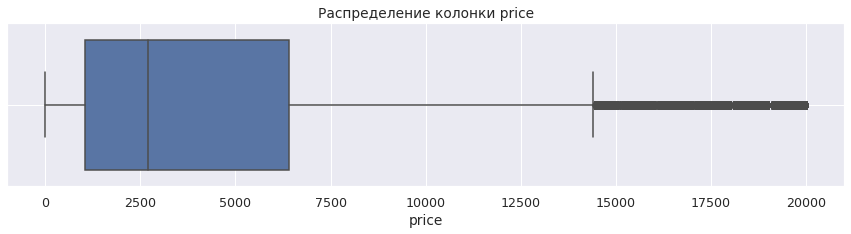

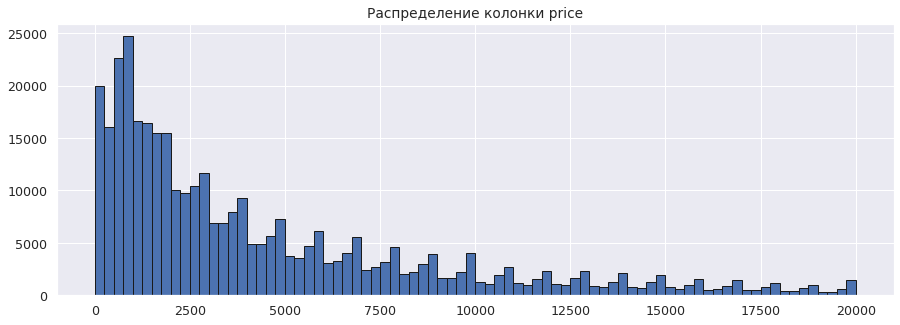

Уникальные значения признака: price [    0     1     2 ... 19998 19999 20000]


In [20]:
distribution(df['price'], 'price')

In [21]:
print(f"Количество автомобилей со стоимостью ниже 100 евро: {len(df.loc[df['price'] < 100])}")

Количество автомобилей со стоимостью ниже 100 евро: 13314


В целевом признаке `price` заметно большое количество нулевых и около нулевых значений, что является явной ошибкой, скорее всего пользователь забыл указать стоимость или ошибся в указании стоимости. Данные значения сложно будет заменить на близкие к действительным, так как необходимо учесть большое количество различных параметров автомобиля и даже в этом случае цена врятли будет соответствовать действительной, что может в итоге сказаться на качестве прогнозируемой цены в будущем. Считаю, что стоимость не может быть меньше 100 евро, поэтому рациональнее будет удалить значения ниже 100 евро. 

In [22]:
df = df.loc[df['price'] > 100]

Теперь изучу признак с годом регистрации.

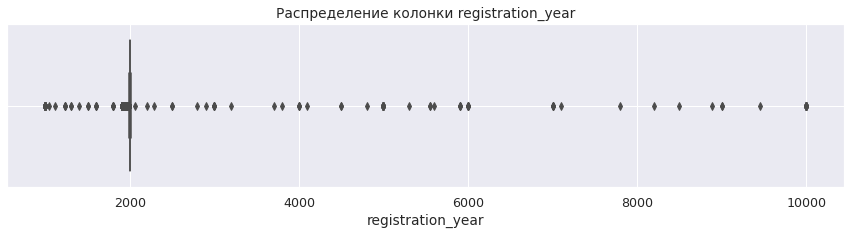

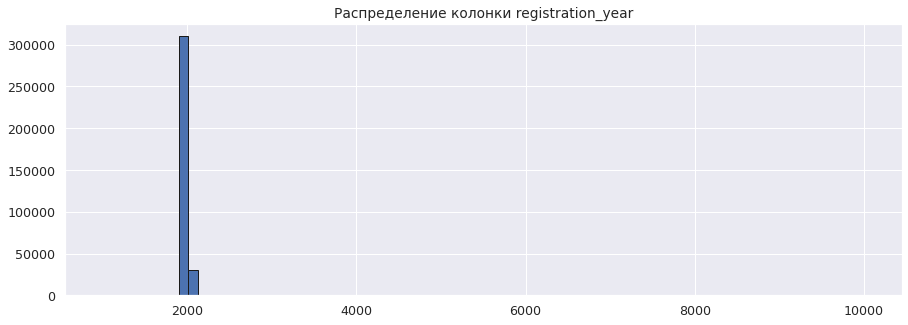

Уникальные значения признака: registration_year [1000 1001 1039 1111 1234 1300 1400 1500 1600 1602 1800 1910 1923 1925
 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1940 1941
 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955
 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969
 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983
 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997
 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011
 2012 2013 2014 2015 2016 2017 2018 2019 2066 2200 2290 2500 2800 2900
 3000 3200 3700 3800 4000 4100 4500 4800 5000 5300 5555 5600 5900 5911
 6000 7000 7100 7800 8200 8500 8888 9000 9450 9999]


In [23]:
distribution(df['registration_year'], 'registration_year')

В признаке с указанием года регистрации автомобиля замечены аномалии, минимальный год регистрации не может быть ренее 1806 года, так в этом году появились первые машины, приводимые в движение двигателями внутреннего сгорания, а в 1885 году появились автомобили используемые газолиновыый или бензиновый двигатель внутреннего сгорания. Так же не может быть автомобилей с датой позже 2016 года, так как уже известно, что крайняя дата скачивания анкеты из базы была в 2016 году. Посмотрю на количество значений с датой регистрации несоответствующие диапазону от 1923 года по 2016 год. Предположу, что на платформе могут быть анкеты с ретро автомобилями.

In [24]:
print(f"Количество автомобилей с регистрацией ранее 1923 года и позже 2016 года: \
{len((df.loc[(df['registration_year'] < 1923) | (df['registration_year'] > 2016)]))}")

Количество автомобилей с регистрацией ранее 1923 года и позже 2016 года: 13747


13747 значений. Данные значения восстановить 
невозможно. Заменить их тоже не получится, даже если производить замену с учетом остальных параметров автомобиля, результат может быть далек от действительного. Поэтому принимаю решение удалить значения до 1910 года и после 2016 года.

In [25]:
df = df.loc[(df['registration_year'] > 1923)]
df = df.loc[(df['registration_year'] <= 2016)]

Рассмотрю признак `power`.

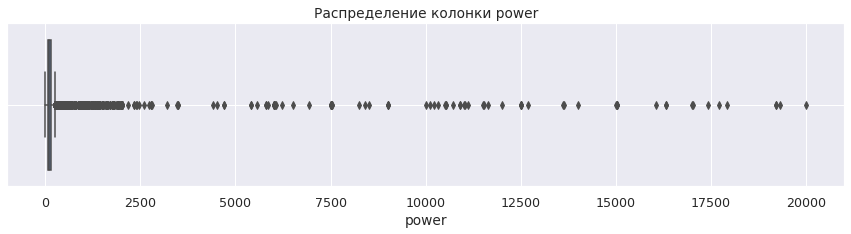

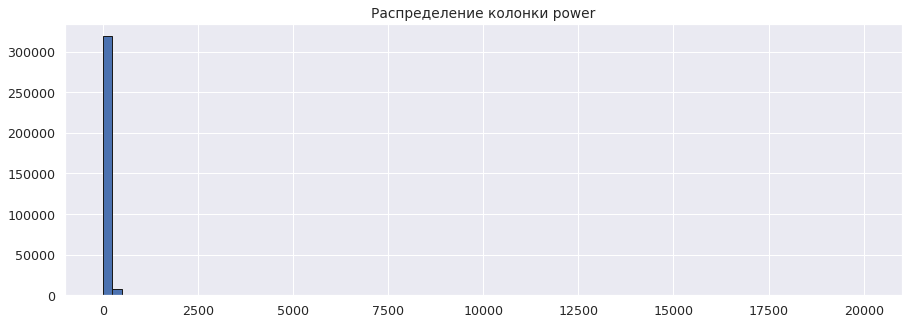

Уникальные значения признака: power [    0     1     2     3     4     5     6     7     8     9    10    11
    12    13    14    15    16    17    18    19    20    21    22    23
    24    25    26    27    28    29    30    31    32    33    34    35
    36    37    38    39    40    41    42    43    44    45    46    47
    48    49    50    51    52    53    54    55    56    57    58    59
    60    61    62    63    64    65    66    67    68    69    70    71
    72    73    74    75    76    77    78    79    80    81    82    83
    84    85    86    87    88    89    90    91    92    93    94    95
    96    97    98    99   100   101   102   103   104   105   106   107
   108   109   110   111   112   113   114   115   116   117   118   119
   120   121   122   123   124   125   126   127   128   129   130   131
   132   133   134   135   136   137   138   139   140   141   142   143
   144   145   146   147   148   149   150   151   152   153   154   155
   156   157   

In [26]:
distribution(df['power'], 'power')

In [27]:
print('Наименование марок автомобилей представленных в датасете')
df['brand'].sort_values().unique()

Наименование марок автомобилей представленных в датасете


array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

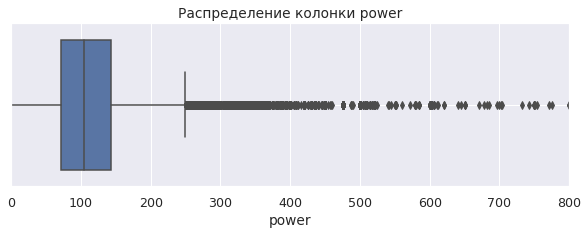

In [28]:
plt.figure(figsize=(10,3))
sns.boxplot(x=df['power'])
plt.xlim([0, 800])
plt.title('Распределение колонки power')
plt.grid(True)

Разброс значений мощности, еще больше удивляет. Очень много аномальных значений. Буду сокращать диапазон значений в соответствии со следующей логикой, попробую изменить нулевые значения медианой по модели автомобиля. Самым мощным легковым автомобилем на данный момент является Dagger GT с мощностью 2028 л.с., такой модели в нашем датасете нет, да и такие мощные автомобили врятли бы продавались на обычной платформе для легковых автомобилей. И глядя на ящик с усами, видно, что выбросы начинаются в диапазоне 500-600 л.с., поэтому максимальное значение мощности возьму 600 л.с., а выше этого значения удалю.

In [29]:
df = df.loc[df['power'] < 600]

In [30]:
df.loc[df['power'] == 0, 'power'] = None
df['power'] = df['power'].fillna(df.groupby('model')['power'].transform('median'))

In [31]:
df['power'].isna().sum()

3959

Осталось 3959 пропусков, их я удалю.

In [32]:
df = df.loc[~df['power'].isna()]
df['power'] = df['power'].astype('int64')

В столбце с информацией о пробеге автомобиля выбросов нет, в соответствии с таблицей с основными статистическими характеристиками, поэтому данный признак я не буду рассматривать на аномалии.

Далее рассмотрю столбец с месяцем регистрации.

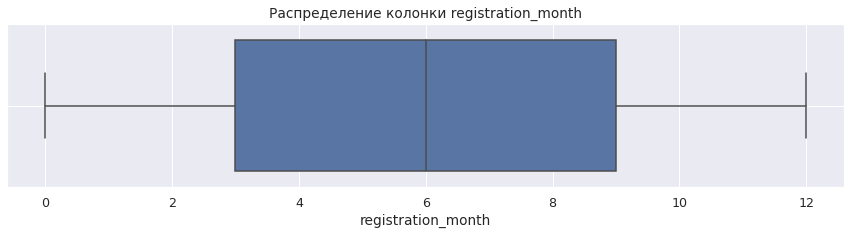

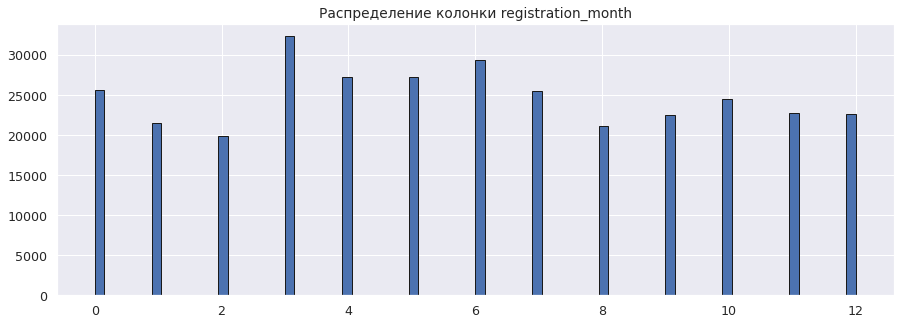

Уникальные значения признака: registration_month [ 0  1  2  3  4  5  6  7  8  9 10 11 12]


In [33]:
distribution(df['registration_month'], 'registration_month')

В колонке `registration_month`, заметен месяц со значением 0, скорее всего это значение присваивается, когда пользователь не указал данные о месяце регистрации. Заполню данное значение случайным образом.

In [34]:
df.loc[df['registration_month'] == 0, 'registration_month'] = pd.Series(
    index=df[df['registration_month']==0].index, data=df[df['registration_month'] != 0]['registration_month'].sample(
        (df['registration_month'] == 0).sum()).values)

Снова проверю таблицу на явные дубликаты и в случае обнаружения удалю их. А так же посмотрю на корреляцию после удаления аномалий.

In [35]:
df.duplicated().sum()

21205

In [36]:
df = df.drop_duplicates()

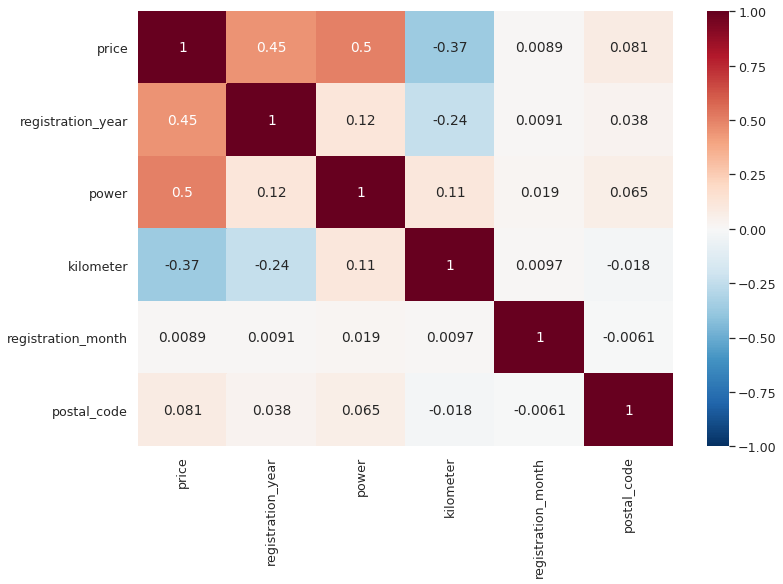

In [37]:
sns.set(font_scale=1.15)
plt.figure(figsize=(12,8))
sns.heatmap(
    df.corr(),        
    cmap='RdBu_r', 
    annot=True, 
    vmin=-1, vmax=1)
plt.show()

Тут уже видно, что с цена коррелирует с годом регистрации, мощностью и пробегом. На цену не влияет почтовый индекс владельца и в большей степени месяц регистрации. Поэтому колонку с месяцем регистрации удалю, она нам не нужна.

In [38]:
df = df.drop('registration_month', axis=1)

Теперь заполню пропуски.

In [39]:
def category(df, sign):
    df = df.fillna('None').value_counts()
    plt.figure(figsize=(16,7))
    plt.xlabel(sign)
    plt.ylabel('количество')
    plt.bar(x=df.index[:20], height=df.values[:20])
    plt.title(f'Распределение признака {sign}')
    plt.show()

In [40]:
def category_mode(column, column1, column2):
    df[column] = df.groupby([column1, column2])[column].transform(
        lambda x: x.fillna((x.mode()[0] if x.count() != 0 else 'unknown')))

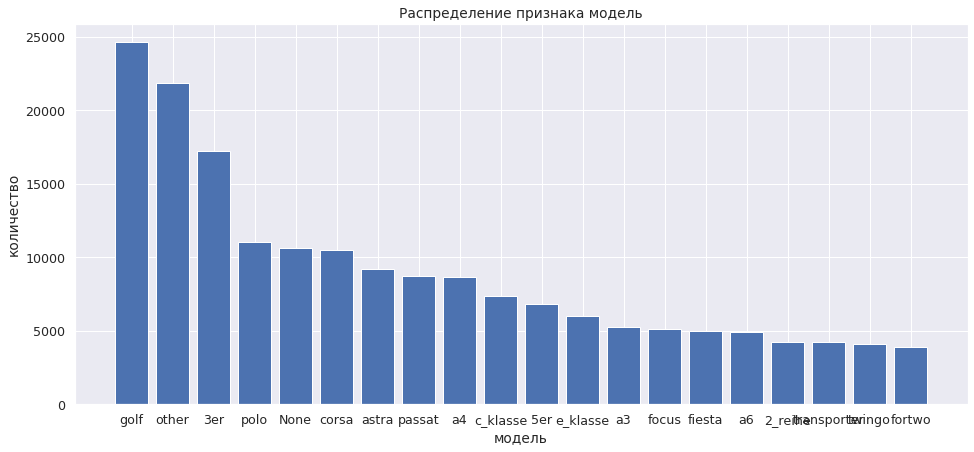

In [41]:
category(df['model'], 'модель')

Самая популярная модел в объявлениях `golf`, но и количество пропусков на 5 месте. Заполню пропуски модой по году регистрации и марке автомобиля, а те значения для которых нет моды, заполню новой категорией `unknown`.

In [42]:
category_mode('model', 'registration_year','brand')

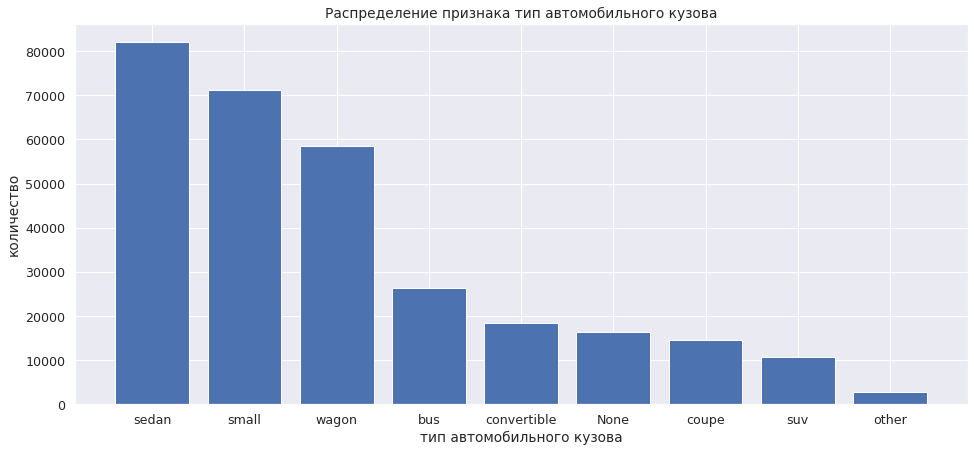

In [43]:
category(df['vehicle_type'], 'тип автомобильного кузова')

Пропусков в признаке `vehicle_type` тоже не мало, заполню их по аналогии, как и признак модель, только уже наиболее частным значением в соответствии с моделью и брендом.

In [44]:
category_mode('vehicle_type', 'model','brand')

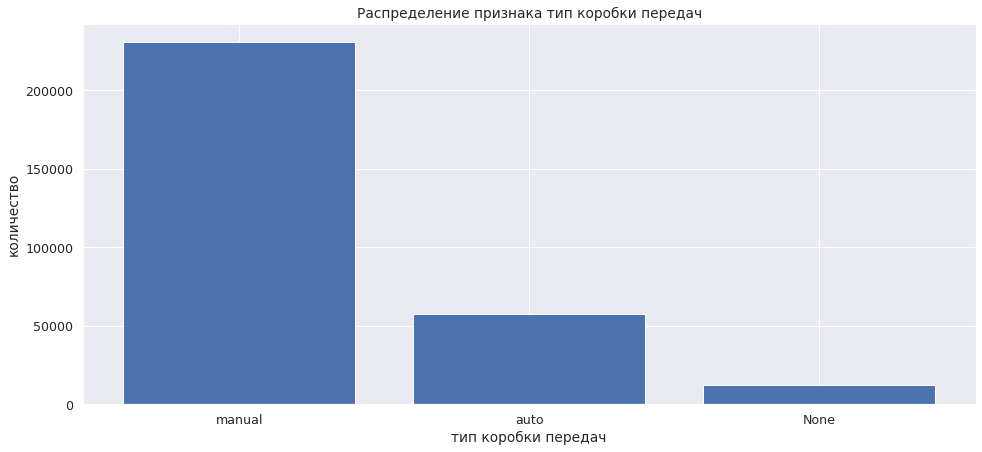

In [45]:
category(df['gearbox'], 'тип коробки передач')

Тип коробки передач тоже заполню модой по модели и бренду.

In [46]:
category_mode('gearbox', 'model','brand')

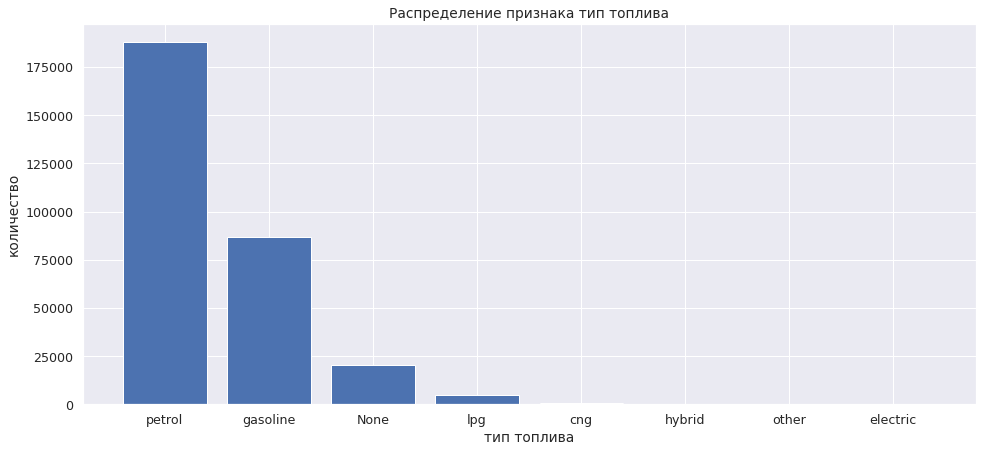

In [47]:
category(df['fuel_type'], 'тип топлива')

И пропуски в колонке с типом топлива тоже заполню модой.

In [48]:
category_mode('fuel_type', 'model','brand')

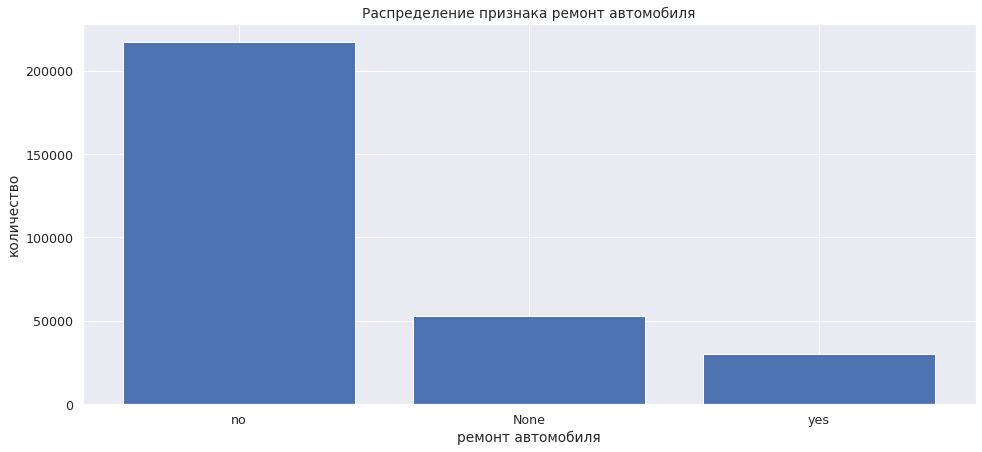

In [49]:
category(df['repaired'], 'ремонт автомобиля')

Пропуски в данном признаке очень интересны. Я склоняюсь к версии, что пользователь специально ничего не ставил в данную колонку, чтобы не указывать, что ремонт был. Поэтому пропуски я заполню значением `yes`, которое говорит о том, что ремонт был.

In [50]:
df['repaired'] = df['repaired'].fillna('yes')

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300775 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              300775 non-null  int64 
 1   vehicle_type       300775 non-null  object
 2   registration_year  300775 non-null  int64 
 3   gearbox            300775 non-null  object
 4   power              300775 non-null  int64 
 5   model              300775 non-null  object
 6   kilometer          300775 non-null  int64 
 7   fuel_type          300775 non-null  object
 8   brand              300775 non-null  object
 9   repaired           300775 non-null  object
 10  postal_code        300775 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 27.5+ MB


In [52]:
finish = df.shape[0]

In [53]:
a = 1-finish/start
b = start-finish
print(f'После обработки таблицы удалено: {b} строк, что соответствует {a:.2%}')

После обработки таблицы удалено: 53594 строк, что соответствует 15.12%


**Вывод:**

При подготовке было выполнено следующее:

- Загружены и узучены данные;
- Найдены и обработаны аномалии в столбцах;
- Заполнены пропуски в категориальных признаках;
- Рассмотрена корреляция влияния количественных признаков на целевой признак;
- Удалены неинформативные признаки.

Таблица подготовлена для обучения моделей.

## Обучение моделей

### Подготовка признаков для обучения

Скопирую таблицу, чтобы использовать копию для CatBoost и LightGBM, которые работают с категориальными признаками, а также выведу категориальные признаки в отдельную переменную.

In [54]:
categorical = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
numeric = ['registration_year', 'power', 'kilometer', 'postal_code']

Разделю таблицу на признаки и целевой признак.

In [55]:
features = df.drop('price', axis=1)
target = df['price']
display(features.shape)
display(target.shape)

(300775, 10)

(300775,)

In [56]:
features_cat = features.copy()
target_cat = target.copy()

Разделю таблицу на обучающую и тестовую выборки и закодирую категориальные признаки.

In [57]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=42)

Для модели линейной регрессии закодирую признаки методом OHE.

In [58]:
train_cat = features_train[categorical]
test_cat = features_test[categorical]

In [59]:
ohe = OneHotEncoder(handle_unknown = 'ignore')
features_train_ohe_cat = ohe.fit_transform(train_cat).toarray()
features_test_ohe_cat = ohe.transform(test_cat).toarray()

In [60]:
train_names_ohe = ohe.get_feature_names(train_cat.columns)
test_names_ohe = ohe.get_feature_names(test_cat.columns)

In [61]:
features_train_lr = features_train[numeric].copy()
features_test_lr = features_test[numeric].copy()

Теперь соединю количественные и категориальные признаки после обработки категориальных признаков методом OHE.

In [62]:
features_train_ohe = pd.concat([features_train_lr,  
                                pd.DataFrame(features_train_ohe_cat,
                                             columns=train_names_ohe,
                                            index=features_train.index)], axis=1)

features_test_ohe = pd.concat([features_test_lr,  
                                pd.DataFrame(features_test_ohe_cat,
                                             columns=test_names_ohe, 
                                             index=features_test.index)], axis=1)

In [63]:
print(features_train_ohe.shape, features_train_ohe.shape)

(225581, 315) (225581, 315)


Проведу масштабирование численных признаков, чтобы масштабирование не применилось для модели линейной регрессии, для того чтобы не было миллиардного значения RMSE.

In [64]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Теперь для моделей деревьев закодирую категориальные признаки методом OE.

In [65]:
encoder = OrdinalEncoder(dtype=int, handle_unknown = 'use_encoded_value', unknown_value=-1)

features_train_oe = features_train.copy()
features_test_oe = features_test.copy()

features_train_oe[categorical] = encoder.fit_transform(features_train_oe[categorical])
features_test_oe[categorical] = encoder.transform(features_test_oe[categorical])

features_train_oe.head()
features_test_oe.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,postal_code
176744,5,-0.093852,1,-1.162622,83,0.577669,6,24,0,-1.017806
109786,3,-0.539040,0,-0.461462,33,0.577669,6,20,1,0.545375
191035,1,-1.429415,1,1.035610,166,0.577669,6,1,0,1.717761
64151,1,1.241710,1,0.391301,97,-2.672595,2,38,0,-0.627011
242638,5,-0.687436,1,-1.238423,151,0.577669,6,23,0,0.936170


Модель LightGBM принимает категориальные признаки в виде типа данных `category`. Поэтому для данной модели изменю тип данных категориальных признаков.

In [66]:
features_train_boost = features_train
features_train_boost[categorical] = features_train_boost[categorical].astype('category')
features_test_boost = features_test
features_test_boost[categorical] = features_test_boost[categorical].astype('category')

In [67]:
features_train_boost

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,postal_code
173108,sedan,-0.984227,manual,-0.082456,laguna,0.577669,petrol,renault,yes,-0.627011
54676,wagon,0.054543,manual,-0.347760,golf,0.577669,gasoline,volkswagen,no,0.154580
237217,wagon,0.944918,manual,-0.271959,golf,-0.099470,gasoline,volkswagen,no,1.717761
340225,sedan,-0.539040,manual,0.580803,3er,0.577669,petrol,bmw,no,0.154580
153220,wagon,-0.093852,auto,1.130362,a4,0.577669,gasoline,audi,no,0.545375
...,...,...,...,...,...,...,...,...,...,...
135778,sedan,-0.242248,auto,3.612848,a8,0.577669,petrol,audi,no,-0.627011
302782,small,-0.242248,manual,-1.219473,polo,0.577669,petrol,volkswagen,yes,-1.799396
149867,sedan,0.054543,manual,1.376715,3er,-1.860029,petrol,bmw,yes,1.326965
167346,sedan,1.241710,manual,-0.707815,fiesta,-0.099470,petrol,ford,no,1.326965


In [68]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

### Обучение моделей

Рассмотрю модели линейной регрессии, дерева решений, случайного леса, LightGBM и CatBoost. Создам списки, в которые будут записываться результаты по каждой модели.

In [69]:
model = ['LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor', 'CatBoostRegressor', 'LGBMRegressor']

**Линейная регрессия**

Рассчитаю метрику RMSE для линейной регрессии. И посмотрю на время обучения модели.

In [70]:
%%time
start = time.time()

lr_model = LinearRegression().fit(features_train_ohe, target_train)

finish = time.time()
time_cvs_lr = round(finish - start, 2)

lr_rmse = cross_val_score(lr_model,
                            features_train_ohe,
                            target_train,
                            cv=cv,
                            scoring='neg_root_mean_squared_error').mean()
  
rmse_lr = round(-lr_rmse, 2)

print('RMSE for LinearRegression: ', rmse_lr)

RMSE for LinearRegression:  2663.88
CPU times: user 1min 36s, sys: 3min 3s, total: 4min 39s
Wall time: 4min 40s


Далее узнаю время предсказания модели, предсказание буду делать на обучающей выборке.

In [71]:
%%time
start = time.time()

pred = lr_model.predict(features_train_ohe)

finish = time.time()
time_p_lr = round(finish - start, 2) 

CPU times: user 271 ms, sys: 273 ms, total: 544 ms
Wall time: 584 ms


**Дерево решений**

Найду лучшие параметры и метрику RMSE с помощью GridSearchCV для модели дерева решений.

In [72]:
%%time

dt_model = DecisionTreeRegressor(random_state=42)

#набор параметров, для поиска лучших
# dt_params = {'max_depth': [int(x) for x in np.linspace(start=2, stop=50, num=5)],
#               'max_leaf_nodes': [int(x) for x in np.linspace(start=20, stop=100, num=10)],
#               'min_samples_leaf': [int(x) for x in np.linspace(start=10, stop=50, num=10)]}
dt_params = {'max_depth': [14], 'max_leaf_nodes': [100], 'min_samples_leaf': [10]}

gs_dt = GridSearchCV(dt_model, dt_params,
                      cv=cv, n_jobs=-1,
                     scoring='neg_root_mean_squared_error')
start = time.time()

model_gs_dt = gs_dt.fit(features_train_oe, target_train)

finish = time.time()
time_gs_dt = round(finish - start, 2)

rmse_dt = round(-gs_dt.best_score_, 2)

print('RMSE for DecisionTreeRegressor: ', rmse_dt)
print('Best params: ', gs_dt.best_params_)
#print('Time predict: ', gs_dt.cv_results_)

RMSE for DecisionTreeRegressor:  2161.08
Best params:  {'max_depth': 14, 'max_leaf_nodes': 100, 'min_samples_leaf': 10}
CPU times: user 2.38 s, sys: 0 ns, total: 2.38 s
Wall time: 2.42 s


GridSearchCV выдал лучшие параметры и лучшую метрику RMSE. Сохраню эти данные и теперь посчитаю время предсказания модели с лучшими параметрами.

In [73]:
%%time
start = time.time()

pred = model_gs_dt.predict(features_train_oe)

finish = time.time()
time_p_dt = round(finish - start, 2) 

CPU times: user 20.6 ms, sys: 0 ns, total: 20.6 ms
Wall time: 19.7 ms


**Случайный лес**

Теперь также с помощью GridSearchCV найду лучшие параметры у случайного леса, вычислю RMSE и обучу модель.

In [74]:
%%time

rf_model = RandomForestRegressor(random_state=42)

#набор параметров, для поиска лучших
# rf_params = {'n_estimators': range(10, 41, 5),
#              'max_depth': range(5, 21, 4),
#              'max_leaf_nodes': [25, 55, 80, 100],
#              'min_samples_leaf': [3, 8, 13, 18]}

rf_params = {'n_estimators': [40],
             'max_depth': [13],
             'max_leaf_nodes': [100],
             'min_samples_leaf': [18]}

gs_rf = GridSearchCV(rf_model, rf_params,
                     cv=cv, n_jobs=-1,
                     scoring='neg_root_mean_squared_error')

start = time.time()

model_gs_rf = gs_rf.fit(features_train_oe, target_train)

finish = time.time()
time_gs_rf = round(finish - start, 2)

rmse_rf = round(-gs_rf.best_score_, 2)

print('RMSE for DecisionTreeRegressor: ', rmse_rf)
print('Best params: ', gs_rf.best_params_)

RMSE for DecisionTreeRegressor:  2106.19
Best params:  {'max_depth': 13, 'max_leaf_nodes': 100, 'min_samples_leaf': 18, 'n_estimators': 40}
CPU times: user 1min 2s, sys: 0 ns, total: 1min 2s
Wall time: 1min 2s


Узнаю время предсказания модели случайного леса.

In [75]:
%%time
start = time.time()

pred = model_gs_rf.predict(features_train_oe)

finish = time.time()
time_p_rf = round(finish - start, 2)

CPU times: user 512 ms, sys: 0 ns, total: 512 ms
Wall time: 517 ms


**CatBoostRegressor**

Опять же с помощью GridSearchCV найду лучшие параметры, рассчитаю RMSE и обучу модель.

In [76]:
%%time

cbr_model = CatBoostRegressor(random_state=42, loss_function='RMSE', logging_level='Silent', cat_features=categorical)
#набор параметров, для поиска лучших
# cbr_params = {'iterations': [50, 500],
#              'depth': [5, 50],
#              'learning_rate': [0.1, 0.25]}

cbr_params = {'iterations': [500],
             'depth': [5],
             'learning_rate': [0.25]}

gs_cbr = GridSearchCV(cbr_model, cbr_params,
                     cv=cv, n_jobs=-1,
                     scoring='neg_root_mean_squared_error')

start = time.time()
model_gs_cbr = gs_cbr.fit(features_train_oe, target_train)

finish = time.time()
time_gs_cbr = round(finish - start, 2)

rmse_cbr = round(-gs_cbr.best_score_, 2)

print('RMSE for DecisionTreeRegressor: ', rmse_cbr)
print('Best params: ', gs_cbr.best_params_)

RMSE for DecisionTreeRegressor:  1658.54
Best params:  {'depth': 5, 'iterations': 500, 'learning_rate': 0.25}
CPU times: user 7min 15s, sys: 0 ns, total: 7min 15s
Wall time: 7min 22s


Далее узнаю время предсказания модели на обучающей выборке.

In [77]:
%%time
start = time.time()

pred = model_gs_cbr.predict(features_train_oe)

finish = time.time()
time_p_cbr = round(finish - start, 2) 

CPU times: user 1.12 s, sys: 0 ns, total: 1.12 s
Wall time: 1.12 s


**LightGBM**

In [78]:
%%time

lgbm_model = LGBMRegressor(random_state=42, objective="RMSE")
#набор параметров, для поиска лучших
# lgbm_params = {'n_estimators': [50, 500],
#              'max_depth': [5, 50],
#              'learning_rate': [0.1, 0.25],
#                'num_leaves': [50, 100]}

lgbm_params = {'n_estimators': [500],
             'max_depth': [50],
             'learning_rate': [0.1],
               'num_leaves': [100]}

gs_lgbm = GridSearchCV(lgbm_model, lgbm_params,
                     cv=cv, n_jobs=-1,
                     scoring='neg_root_mean_squared_error',
                     verbose=False)

start = time.time()

model_gs_lgbm = gs_lgbm.fit(features_train_boost, target_train)

finish = time.time()
time_gs_lgbm = round(finish - start, 2)

rmse_lgbm = round(-gs_lgbm.best_score_, 2)

print('RMSE for DecisionTreeRegressor: ', rmse_lgbm)
print('Best params: ', gs_lgbm.best_params_)

RMSE for DecisionTreeRegressor:  1588.0
Best params:  {'learning_rate': 0.1, 'max_depth': 50, 'n_estimators': 500, 'num_leaves': 100}
CPU times: user 1h 57min 4s, sys: 28.8 s, total: 1h 57min 33s
Wall time: 1h 58min 21s


In [79]:
%%time
start = time.time()

pred = model_gs_lgbm.predict(features_train_boost)

finish = time.time()
time_p_lgbm = round(finish - start, 2) 

CPU times: user 14.9 s, sys: 0 ns, total: 14.9 s
Wall time: 15.3 s


**Вывод:**

В данном разделе было выполнено обучение моделей, в том числе:

1. Произведена подготовка признаков для обучения:
 - датасет разделен на на признаки и целевой признак;
 - датасет разделен на две выборки - обучающую и тестовую;
 - произведена кодировка категориальных признаков методами OHE и OE, а для модели LightGBM категориальные признаки приведены к типу данных - `category`;
 проведено масштабирование количественных признаков.
2. Выролнен подбор лучших параметров для обучения моделей;
3. Проведено обучение моделей:
 - LinearRegression;
 - DecisionTreeRegressor;
 - RandomForestRegressor;
 - CatBoostRegressor;
 - LGBMRegressor.
4. Рассчитана метрика RMSE для каждой модели.
5. Посчитано время обучения и время предсказания моделей.

## Анализ моделей

Соберу все полученные данные на этапе обучения моделей и проанализурую полученные результаты: время обучения, время предсказания и качество моделей и выберу лучшую модель.

In [80]:
results = pd.DataFrame({'RMSE_score' : [rmse_lr, rmse_dt, rmse_rf, rmse_cbr, rmse_lgbm],
                        'Time_fit' : [time_cvs_lr, time_gs_dt, time_gs_rf, time_gs_cbr, time_gs_lgbm],
                        'Time_predict' : [time_p_lr, time_p_dt, time_p_rf, time_p_cbr, time_p_lgbm]}, index=model).sort_values(by='RMSE_score', ascending=False)
results

,RMSE_score,Time_fit,Time_predict
LinearRegression,2663.88,54.54,0.58
DecisionTreeRegressor,2161.08,2.42,0.02
RandomForestRegressor,2106.19,62.87,0.52
CatBoostRegressor,1658.54,442.08,1.12
LGBMRegressor,1588.00,7101.72,15.32


Рассмотрю критерии, которые важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели;
- значение метрики RMSE должно быть меньше 2500.

Рассматривая результаты, отбраженные в таблице, можно заметить, что худший результат показывает модель LinearRegression, который не соответствует требованию заказчика - значение метрики RMSE должно быть меньше 2500. Данную модель дальше рассматривать не буду.

Оставшиеся четыре модели соответствуют данному требованию. Быстрее всего обычается модель дерева решений, а лучший результат показывает модель  

Быстрее всего обучается и предсказывает модель DecisionTreeRegressor, но у нее хоть и соответствует метрика RMSE заявленому качество, но она хуже, чем у оставшихся моделей. У RandomForestRegressor, чуть лучше результат, но обучение занимает больше времени.

Лучший результат метрики качества RMSE показывает модель LGBMRegressor, он не много лучше модели CatBoostRegressor, но модель LGBMR обучается почти в 7 раз быстрее, хоть и предсказывает дольше всех моделей, но это не критично, так как предсказание моделей длится не дольше нескольких секунд.

Поэтому опираясь на критерии заказчика лучшей моделью выбираю LGBMRegressor и теперь проверю ее качество на тестовой выборке.



In [81]:
%%time
start = time.time()

final_pred = model_gs_lgbm.predict(features_test_boost)

finish = time.time()
time_p_test = round(finish - start, 2) 

rmse_test = mean_squared_error(target_test, final_pred, squared=False)

print(f'Время предсказания модели на тестовой выборке {time_p_test}')
print(f'Итоговый RMSE на тестовой выборке: {round(rmse_test, 2)}')

Время предсказания модели на тестовой выборке 4.95
Итоговый RMSE на тестовой выборке: 1574.04
CPU times: user 4.99 s, sys: 0 ns, total: 4.99 s
Wall time: 4.96 s


Значение RMSE модели показало отличный результат, он практически не отличается от значения на обучающей выборки. Значит модель можно использовать и она подходит по критериям Заказчику.

# Итоговый вывод

В данном проекте были выполнены следующие задачи:
- изучены, обработаны и приведены в соответствие данные датасета содержащего пропуски, дубликаты, аномальные значения, выбросы и лишние признаки;
- подготовлены выборки для обучения моделей;
- обучены две бустинг модели, модель линейной регрессии, ансамблевая модель - случайный лес и модель решающего дерева;
- качество моделей рассмотрено на метрике RMSE;
- проанализированы результаты обученных моделей на соответствие критерий выставленных Заказчиком.

Лучшей моделью выбрана модель LGBMRegressor, она показывает лучший результат при средней скорости в сравнении со всеми обученными моделями.